In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline

#performance metrics
training_neural = training_kmeans = training_graph = \
falsep_neural = falsep_kmeans = falsep_graph = p_neural = \
falsen_neural = falsen_kmeans = falsen_graph = \
p_kmeans = p_graph = l_neural = l_kmeans = l_graph = 0


#merge data sets
def data_collection(value):
    import glob
    glob.glob("dnc_complaint_numbers_2019-05-*.csv")

    merged_data = pd.DataFrame()
    for f in glob.glob('dnc_complaint_numbers*.csv'):
        df = pd.read_csv(f)
        merged_data = merged_data.append(df, ignore_index = True)
        
    
    
    #create an index column for easy edge merging for graph analysis    
    merged_data = merged_data.reset_index()
    #merged_data.columns[0] = 'index'
   # merged_data['index'] = merged_data.index + 0
 
    #change the headings to something simplier to work with
    merged_data.rename(columns={'Company_Phone_Number':'number','Consumer_State':'state',
                         'Consumer_Area_Code':'Area','Recorded_Message_Or_Robocall':'Type'
                        }, inplace = True)
    merged_data['Subject_'] = merged_data['Subject']
    merged_data['state_'] = merged_data['state']
    
    
    #prepare data for graph analysis
    column_edge = 'number'
    column_ID = 'index'
    
    data_to_merge = merged_data[[column_ID , column_edge]].dropna(subset=[column_edge]).drop_duplicates()    
   


    
    #We select the specific portion of the dataset that will be useful for out analysis
    required_data = merged_data[['state','Area','Subject','Type']].copy()
    data_to_merge = merged_data[['index','state','Area','Subject','Type','number']].copy()
    
    #edge analysis data preparation continues
    # To create connections between people who have the same number,
    # join data with itself on the 'ID' column.
    data_to_merge = data_to_merge.sample(50)
    data_to_merge = data_to_merge.merge(
        data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
        on=column_edge
    )
    
   
   
    #remove rows containing any NaN values
    required_data = required_data.dropna(how = 'any')
    data_to_merge = data_to_merge.dropna(how = 'any')
    
    #change 'Type' column to numeric values
    type = {'N': 1, 'Y':2}
    required_data.Type = [type[item] for item in required_data.Type]
    
    required_data['Subject'].unique()
    
    #change 'Subect' column to numeric values
    uni_subject_values = required_data['Subject'].unique()
    subject_values = np.arange(uni_subject_values.size, dtype = int)
    subject_dict = dict(zip(uni_subject_values,subject_values))
    required_data.Subject = [subject_dict[item] for item in required_data.Subject]
    
    
    #change 'State' column to numeric values
    uni_state_values = required_data['state'].unique()
    uni_state_values.size
    state_values = np.arange(uni_state_values.size, dtype = int)
    state_dict = dict(zip(uni_state_values,state_values))
    required_data.state = [state_dict[item] for item in required_data.state]
    
    
    if(value == 1):
        return required_data
    else:
        return data_to_merge

   
#required data for neural network and k-means
required_data1 = data_collection(1)

required_data1 = required_data1.sample(4500)
 #First experiement input to check for type of call
a = required_data1 [['state','Area','Subject']].copy()

X = a.values

#possible first experiment outcome
y = required_data1['Type'].values
y = np.matrix(y)

#required_data.columns.values
required_data2 = data_collection(0)
required_data2 = required_data2.sample(40)
required_data2.sample(10)

#required data for edge 

,index,state,Area,Subject,Type,number,index_2
43,2393,Alabama,256,"Calls pretending to be government, businesses,...",Y,2014267525,2393
44,32498,Oklahoma,918,Medical & prescriptions,Y,9184828021,32498
66,53748,Florida,813,"Energy, solar, & utilities",Y,8137568587,53748
46,426,New Jersey,908,Work from home & other ways to make money,N,8563360951,426
53,39111,Illinois,608,"Reducing your debt (credit cards, mortgage, st...",Y,8296450037,39111
60,73503,New York,718,No Subject Provided,N,8883111572,73503
41,24900,California,408,No Subject Provided,N,7738690964,24900
47,43848,Wisconsin,262,"Reducing your debt (credit cards, mortgage, st...",Y,2623281840,43848
65,27042,New York,315,No Subject Provided,Y,3154722506,27042
38,52969,Utah,435,Other,Y,4359157112,52969


In [18]:
#we remove the phone number because we realise that it didnt contribute to the result
required_data1.sample(10)

,state,Area,Subject,Type
43523,38,828,4,2
8551,1,805,12,2
27985,40,617,0,2
41294,1,310,7,1
28443,16,954,9,1
115,2,856,2,1
33108,13,718,1,2
67548,13,315,0,2
22848,30,920,1,1
26162,13,212,1,2


In [3]:
import timeit
class NeuralNetwork():
    
    def __init__(self):
        # seeding for random number generation
        np.random.seed(1)
        
        #converting weights to a 3 by 1 matrix with values from -1 to 1 and mean of 0
        self.synaptic_weights = 2 * np.random.random((3, 1)) - 1

    def sigmoid(self, x):
        #applying the sigmoid function
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        #computing derivative to the Sigmoid function
        return x * (1 - x)

    def train(self, training_inputs, training_outputs, training_iterations):
        
        #training the model to make accurate predictions while adjusting weights continually
        for iteration in range(training_iterations):
            #siphon the training data via  the neuron
            output = self.think(training_inputs)

            #computing error rate for back-propagation
            error = training_outputs - output
            
            #performing weight adjustments
            adjustments = np.dot(training_inputs.T, error * self.sigmoid_derivative(output))

            self.synaptic_weights += adjustments

    def think(self, inputs):
        #passing the inputs via the neuron to get output   
        #converting values to floats
        
        inputs = inputs.astype(float)
        output = self.sigmoid(np.dot(inputs, self.synaptic_weights))
        return output


if __name__ == "__main__":

    #initializing the neuron class
    neural_network = NeuralNetwork()


    start_time = timeit.default_timer()
    global training_neural
    training_neural = timeit.default_timer() - start_time
   
    print("Beginning Randomly Generated Weights: ")
    print(neural_network.synaptic_weights)



    #training taking place
    neural_network.train(X, y, 150000)
    


    print("Ending Weights After Training: ")
    print(neural_network.synaptic_weights)


Beginning Randomly Generated Weights: 
[[-0.16595599]
 [ 0.44064899]
 [-0.99977125]]
Ending Weights After Training: 
[[-0.16595599]
 [ 0.44064899]
 [-0.99977125]]


In [19]:
for index, row in data_collection(1).sample(100).iterrows():
    result = neural_network.think(np.array([row['state'], row['Area'], row['Subject']]))
    if(int(row['Type']) == 1):
        if(round(result[0]) != 1):
            global falsep_neural
            falsep_neural += 1
    elif(int(row['Type']) != 1):
        if(int(round(result[0])) != 2):
            global falsen_neural
            falsen_neural += 1
            

            
start_time = timeit.default_timer()
global l_neural
l_neural = timeit.default_timer() - start_time

print("Neural Network testing Result: Test dataset = 100\n Training time : {} \n False Positive: {} \n False Negative: {} \n Latency Time: {}".format(training_neural,falsep_neural,falsen_neural,l_neural))

Neural Network testing Result: Test dataset = 100
 Training time : 0 
 False Positive: 0 
 False Negative: 75 
 Latency Time: 3.409999953873921e-05


[[ 16.67245658 780.27419355   2.99627792]
 [ 17.22814601 370.86599424   2.82612872]]


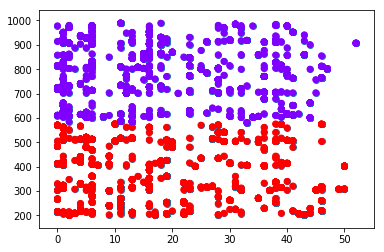

In [20]:
from sklearn.cluster import KMeans

plt.scatter(X[:,0],X[:,1], label='True Position')  

kmeans = KMeans(n_clusters=2)  
kmeans.fit(X)

print(kmeans.cluster_centers_)  

#print(kmeans.labels_)  

plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')  

start_time = timeit.default_timer()
global training_kmeans
training_kmeans = timeit.default_timer() - start_time


In [21]:
kmeans.predict([[0, 0, 0], [16.36842105, 573.21052632, 2.63157895]])
for index, row in data_collection(1).sample(100).iterrows():
    result = kmeans.predict([[0, 0, 0], [row['state'], row['Area'], row['Subject']]])
    result = neural_network.think(np.array([row['state'], row['Area'], row['Subject']]))
    if(int(row['Type']) == 1):
        if(round(result[0]) != 1):
            global falsep_kmean
            falsep_kmeans += 1
            print(falsep_kmeans)
    elif(int(row['Type']) != 1):
        if(int(round(result[0])) != 2):
            global falsen_kmeans
            falsen_kmeans += 1


start_time = timeit.default_timer()

global l_kmeans
l_kmeans = timeit.default_timer() - start_time

print("K-Means testing Result: Test dataset = 100\n Training time : {} \n False Positive: {} \n False Negative: {} \n Latency Time: {}".format(training_kmeans,falsep_kmeans,falsen_kmeans,l_kmeans))

K-Means testing Result: Test dataset = 100
 Training time : 4.470000021683518e-05 
 False Positive: 0 
 False Negative: 70 
 Latency Time: 3.3799999073380604e-05


In [22]:
data_to_merge = required_data2 
d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]
    
# To avoid counting twice the connections (person 1 connected to person 2 and person 2 connected to person 1)
# we force the first ID to be "lower" then ID_2
d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)
    


In [23]:
import networkx as nx

column_ID = 'index'
column_edge = 'number'

G = nx.from_pandas_edgelist(df=required_data2, source=column_ID, target=column_ID+'_2', edge_attr=column_edge)

G.add_nodes_from(nodes_for_adding=required_data2.index.tolist())

# Create the connections in the graph
links_attributes = {tuple(row[[column_ID, column_ID+"_2"]]): {column_edge: row[column_edge]} for i,row in required_data2.iterrows()}

G.add_edges_from(links_attributes) # create the connection, without attribute. Check it with G.get_edge_data(3,5)
nx.set_edge_attributes(G=G, values=links_attributes) # adds the attribute. Check it with G.get_edge_data(3,5)



In [24]:
#%matplotlib inline
G.nodes()


NodeView((46363, 62648, 20009, 67646, 1603, 73503, 60021, 52099, 78334, 48919, 25187, 27042, 40924, 1636, 24900, 52402, 16424, 12243, 41531, 42558, 32498, 42829, 8799, 7410, 63329, 14123, 43848, 52969, 71795, 47652, 64903, 53748, 39111, 75533, 51600, 12966, 426, 18910, 2393, 45879, 1, 42, 73, 56, 51, 60, 55, 62, 50, 68, 54, 65, 61, 75, 41, 59, 48, 71, 64, 58, 44, 57, 39, 49, 76, 69, 47, 38, 70, 79, 77, 66, 53, 74, 63, 78, 46, 0, 43, 52))

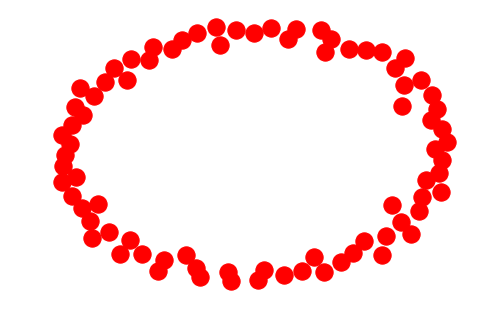

In [25]:
nx.draw(G)

In [26]:
{row[column_ID]:row['number'] +' '+ row['Type'] for i,row in required_data2.iterrows()}

{46363: '8318977091 Y',
 62648: '6317539746 N',
 20009: '80043332 Y',
 67646: '9169102246 N',
 1603: '3469981949 Y',
 73503: '8883111572 N',
 60021: '7342342497 Y',
 52099: '5627700000 N',
 78334: '8662045853 Y',
 48919: '8593836333 N',
 25187: '4089600110 Y',
 27042: '3154722506 Y',
 40924: '5208893150 Y',
 1636: '8473232841 Y',
 24900: '7738690964 N',
 52402: '8103690718 Y',
 16424: '5186522128 Y',
 12243: '4058507620 Y',
 41531: '22551117613 Y',
 42558: '7738764864 Y',
 32498: '9184828021 Y',
 42829: '2023382986 Y',
 8799: '8333004824 Y',
 7410: '8452156980 N',
 63329: '2026420820 Y',
 14123: '9123350422 N',
 43848: '2623281840 Y',
 52969: '4359157112 Y',
 71795: '5853148117 N',
 47652: '8722347294 Y',
 64903: '3126425990 N',
 53748: '8137568587 Y',
 39111: '8296450037 Y',
 75533: '2012075596 N',
 51600: '6825031377 Y',
 12966: '3150689375 N',
 426: '8563360951 N',
 18910: '2152382274 Y',
 2393: '2014267525 Y',
 45879: '2403074397 Y'}

In [27]:

nx.set_node_attributes(G, {row[column_ID]:{'number': row['number']} for i, row in required_data2.iterrows()})

In [28]:
EDGE_SIZE = {
    'number': 2,
    'Type': 1,
}

EDGE_COLOR = {
    'number': 'purple',
    'Type': 'red',
}

def clean_edge(edge):
    s.edge[edge[0], edge[1]].values()

def c_(list_edges): return [a for a in list_edges if a in list(EDGE_COLOR.keys())]
    
# For nx.Graph()
def edge_sizes(s): return [EDGE_SIZE[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one size
def edge_colors(s): return [EDGE_COLOR[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one color

# For nx.MultiDiGraph()
def edge_sizes(s): return [EDGE_SIZE[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one size
def edge_colors(s): return [EDGE_COLOR[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one color

def draw(s):
    pos = nx.spring_layout(s, scale=0.5)
    node_labels = dict((n,d['number']) for n,d in s.nodes(data=True))
#     labels = {**node_labels, **edge_labels}
    nx.draw(s, pos=pos, width=edge_sizes(s), edge_color=edge_colors(s), alpha=0.8, arrows=False, node_color='lightgrey', node_size=400,
            labels=node_labels, 
            font_color='black', font_size=8, font_weight='bold',
           )
    edge_labels = dict(((u,v),list(d.values())[0]) for u,v,d in G.edges(data=True))
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size=8)

In [29]:
degrees = list(nx.degree(G))

In [30]:
pd.DataFrame([list(d) for d in degrees], columns=['ID', 'degree']).sort_values('degree', ascending=False).head(5)

,ID,degree
0,46363,2
21,42829,2
23,7410,2
24,63329,2
25,14123,2
